In [62]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qSMLM.psf.psf2d.psf2d import *
from scipy.special import comb

In [199]:
def _mu(theta,npixels,nparticles,patch_hw=5):
    x = np.arange(0,2*patch_hw); y = np.arange(0,2*patch_hw)
    X,Y = np.meshgrid(x,y)
    mu = np.zeros((npixels,npixels),dtype=np.float32)
    for n in range(nparticles):
        x0,y0,sigma,N0 = theta[:,n]
        patchx, patchy = int(round(x0))-patch_hw, int(round(y0))-patch_hw
        x0p = x0-patchx; y0p = y0-patchy
        lam = lamx(X,x0p,sigma)*lamy(Y,y0p,sigma)
        mu[patchx:patchx+2*patch_hw,patchy:patchy+2*patch_hw] += lam
    return mu

def ring(n,radius=3,phase=0):
    thetas = np.arange(0,n,1)*2*np.pi/n
    xs = radius*np.cos(thetas+phase)
    ys = radius*np.sin(thetas+phase)
    return xs,ys

def computeP(theta,patch_hw=5):

    x = np.arange(0,2*patch_hw); y = np.arange(0,2*patch_hw)
    X,Y = np.meshgrid(x,y)
    npixels = config['npixels']
    nparticles = config['particles']
    P = np.zeros((nparticles, npixels*npixels))
    for n in range(nparticles):
        mu = np.zeros((npixels,npixels),dtype=np.float32)
        x0,y0,sigma,N0 = theta[:,n]
        patchx, patchy = int(round(x0))-patch_hw, int(round(y0))-patch_hw
        x0p = x0-patchx; y0p = y0-patchy
        lam = lamx(X,x0p,sigma)*lamy(Y,y0p,sigma)
        mu[patchx:patchx+2*patch_hw,patchy:patchy+2*patch_hw] += lam
        P[n,:] = mu.flatten()
    return P

def computeB(nparticles,K):
    binary_array = np.array([1] * K + [0] * (nparticles - K), dtype=int)
    B = np.array(list(set(itertools.permutations(binary_array, nparticles))))
    return B.T

def computeEind(npixels):
    """Get indexers for the E matrix"""
    x = np.ones((npixels**2,))
    mask = np.arange(len(x)) % npixels == 0
    x[mask] = 0; x = np.roll(x,-1)
    A = np.diag(x,k=1) #horizontally adjacent
    B = np.diag(x,k=-1) #vertically adjacent

    x = np.ones((npixels**2-npixels,))
    mask = np.arange(len(x)) % npixels == 0
    x[mask] = 0; x = np.roll(x,-1)
    C = np.diag(x,k=npixels+1) #right diagonal
    D = np.diag(x,k=-npixels-1) #left diagonal
    F = np.eye(npixels**2)
    Aind = np.where(A > 0); Bind = np.where(B > 0)
    Cind = np.where(C > 0); Dind = np.where(D > 0)
    Find = np.where(F > 0)
    return Aind,Bind,Cind,Dind,Find

def computeSind(npixels):
    """Get indexers for the covariance map"""
    checker = np.indices((2*npixels-1,2*npixels-1)).sum(axis=0) % 2
    checker = 1-checker
    checker[::2,:] *= 2
    checker[::2,:] += 2
    V = (checker == 0).astype(np.uint8)
    RL = (checker == 1).astype(np.uint8)
    H = (checker == 2).astype(np.uint8)
    D = (checker == 4).astype(np.uint8)
    Vind = np.where(V > 0); RLind = np.where(RL > 0)
    Hind = np.where(H > 0); Dind = np.where(D > 0)
    return Vind, RLind, Hind, Dind

def computeE(config,r=4,patch_hw=5,ring_radius=10):
    theta = np.zeros((4,config['particles']))
    nx,ny = config['npixels'],config['npixels']
    xsamp,ysamp = ring(config['particles'],radius=ring_radius)
    x0 = nx/2; y0 = ny/2
    theta[0,:] = xsamp + x0
    theta[1,:] = ysamp + y0
    theta[2,:] = config['sigma']
    theta[3,:] = config['N0']
    mu = _mu(theta,config['npixels'],config['particles'])
    
    #need object of shape (K,K,npixels**2,npixels**2)

    npixels = config['npixels']
    Kmax = 2; #single photon counts only
    Omega = np.zeros((Kmax+1,npixels**2))
    for K in range(Kmax+1):
        Nck = comb(config['particles'],K)
        P = computeP(theta) # nparticles, npixels**2 (columns are probs emitters emit into that pixel)
        #print(P.shape)
        B = computeB(config['particles'],K) # nparticles, 2Nck
        #print(B.shape)
        P = np.repeat(P[:,:,np.newaxis],Nck,axis=2) #nparticles, npixels**2, Nck
        #print(P.shape)
        B = np.repeat(B[:,np.newaxis,:],npixels**2,axis=1) #nparticles, npixels**2, Nck
        #print(B.shape)
        R = np.power(P,B)*np.power(1-P,1-B)
        Prod = np.prod(R,axis=0)
        #print(Prod.shape)
        R = np.sum(Prod,axis=1)
        #print(R.shape)
        #plt.plot(R)
        Omega[K,:] = R

    Chi = np.arange(0,Kmax+1,1)
    Chi = np.repeat(Chi[:,np.newaxis],npixels**2,axis=1)
    print(Omega.shape)
    E = np.sum(Chi*Omega,axis=0)  #<XY> = <X><Y>
    plt.plot(E)
    return np.outer(E,E), mu


(3, 400)


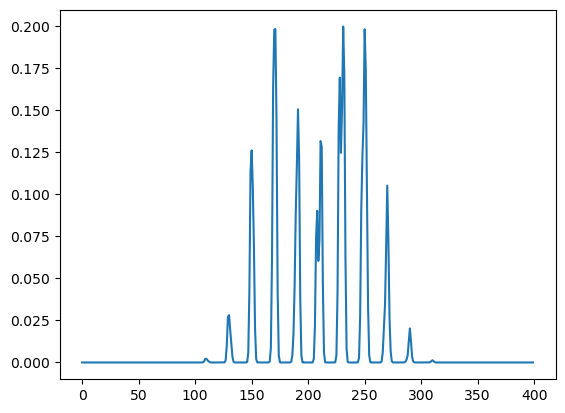

In [200]:
config = {"particles": 5,"npixels": 20,"sigma": 0.92,"N0": 0.5,"eta": 1.0}
E,mu = computeE(config,ring_radius=2)
Eh,Ev,Er,El,Ed = computeEind(config['npixels'])
Vind, RLind, Hind, Dind = computeSind(config['npixels'])

In [186]:
Ehvals = E[Eh]
Evvals = E[Ev]
Ervals = E[Er]
Elvals = E[El]
Edvals = E[Ed]

In [179]:
npixels = config['npixels']
CovR = np.zeros((2*npixels-1,2*npixels-1))
CovR[Vind] = Evvals #looks weird, probably indexing issue
CovR[RLind] = Ervals
CovR[Hind] = Ehvals
CovR[Dind] = Edvals

CovL = np.zeros((2*npixels-1,2*npixels-1))
CovL[Vind] = Evvals
CovL[RLind] = Elvals
CovL[Hind] = Ehvals
CovL[Dind] = Edvals

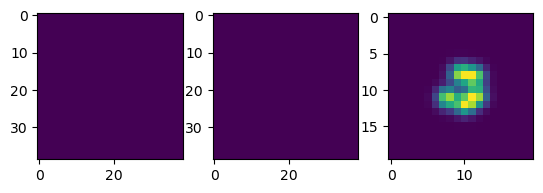

In [180]:
fig,ax=plt.subplots(1,3)
ax[0].imshow(CovL); ax[1].imshow(CovR); ax[2].imshow(mu)